<a href="https://colab.research.google.com/github/PatrickP-Student/ENEL645-Assignment2/blob/Dev/assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02 - CIFAR10 Image Classification

In this assignment your team will design a fully connected neural network and a convolutional neural network (CNN) models for classifiying the CIFAR10 image dataset. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. I expect you to try different configurations (models, train/validtion split, etc.), but for your submission, leave just the best fully connected and the best CNN models.
    - Name the notebook as enel645__assignment02__team_(team number).ipynb
2. The weights of your best fully connected neural network model and your best CNN model 
    - Name the weights files as team__(team number)__FCN.h5 (fully connected model) and team__(team number)__CNN.h5 (CNN model)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page.
    
We will be using the CIFAR10 dataset. The dataset alerady comes with a test set and you shouldn't change it. It is up to you to determine how to split your development set into training and validation sets. Use variable names consistent with the variables pre-filled in this document.


You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on (more details in the rubric):

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.optimizers import SGD

## 1. Load your data

In [3]:
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print('Development set: ', X_dev.shape)
print('Test set: ', X_test.shape)
print('Number of unique classes: ',np.unique(Y_dev).size)
print('Unique classes: ',np.unique(Y_dev))

170500096/170498071 [==============================] - 4s 0us/step
Development set:  (50000, 32, 32, 3)
Test set:  (10000, 32, 32, 3)
Number of unique classes:  10
Unique classes:  [0 1 2 3 4 5 6 7 8 9]


## 2. Explore your data 

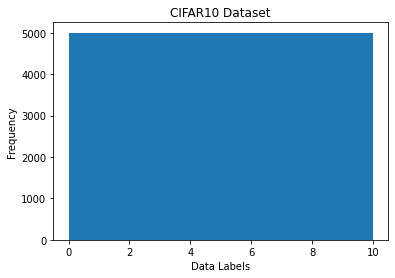

In [4]:
plt.figure()
plt.hist(Y_dev, bins = range(11))
plt.xlabel('Data Labels')
plt.ylabel('Frequency')
plt.title('CIFAR10 Dataset')
plt.show()

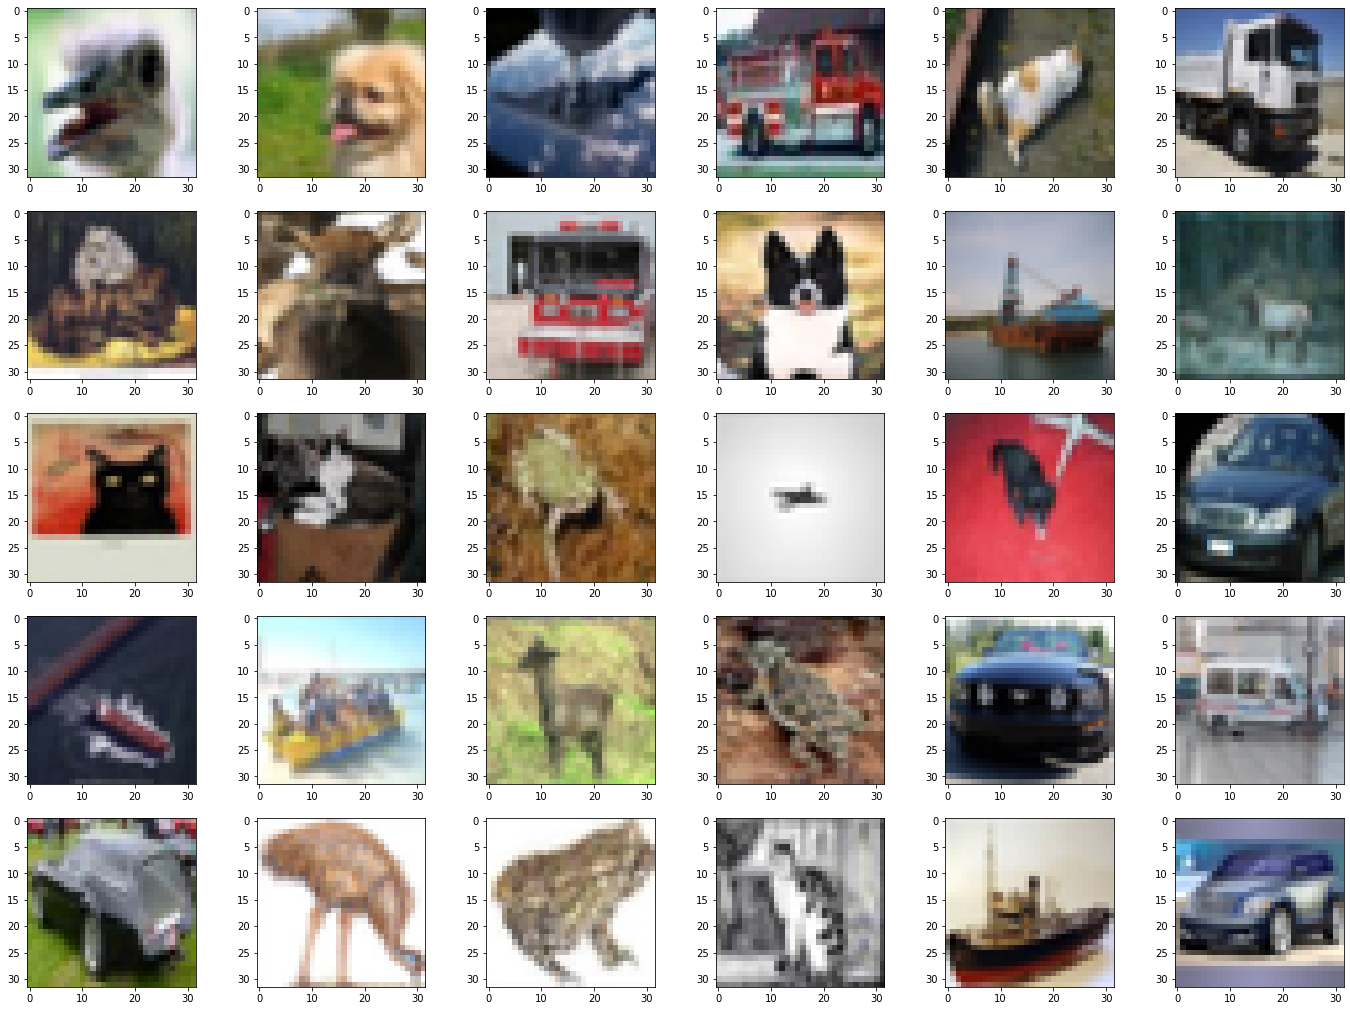

In [20]:
sample_indexes = np.random.choice(np.arange(X_dev.shape[0], dtype = int), size = 30, replace = False)
plt.figure(figsize= (24, 18))
for (ii, jj) in enumerate(sample_indexes):
  plt.subplot(5, 6, ii+1)
  plt.imshow(X_dev[jj], cmap = 'gray')
plt.show()

In [5]:
# shuffle the dataset first 
indexes = np.arange(Y_dev.size, dtype=int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

In [6]:
# split the data into training and validation sets
nsplit = int (0.8*Y_dev.size) # split into 80% training, and 20% validation

X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]

X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

print('Shape of training dataset:',X_train.shape)
print('Shape of validation dataset:',X_val.shape)

Shape of training dataset: (40000, 32, 32, 3)
Shape of validation dataset: (10000, 32, 32, 3)


In [7]:
print('Development set ->   min:',X_train.min(),'max:',X_train.max(),'mean:',round(X_train.mean(),3),'std:',round(X_train.std(),3))
print('Test set ->   min:',X_val.min(),'max:',X_val.max(),'mean:',round(X_val.mean(),3),'std:',round(X_val.std(),3))

Development set ->   min: 0 max: 255 mean: 120.879 std: 64.154
Test set ->   min: 0 max: 255 mean: 120.023 std: 64.129


Since the desciptive statistics between the training and validation datasets are very similar, that shows our data is distributely evenly and balanced.

## 3. Represent your labels using one hot encoding

In [8]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

# now, we can visualize what encoding this vector causes the data to look like
print('Before encoding this vector:\n',Y_train[:5])
print()
print('After encoding this vector:\n',Y_train_oh[:5])

Before encoding this vector:
 [[4]
 [5]
 [8]
 [1]
 [1]]

After encoding this vector:
 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 4. Data scaling and Data augmentation

In [9]:
# Different Data Scaling options
# 0 is min-max normalization and 1 is mean/std normalization
norm_type = 0 

if norm_type == 0:
  X_train = X_train/X_train.max()
  X_val = X_val/X_val.max()
  X_test = X_test/X_test.max()
elif norm_type == 1:
  train_mean = X_train.mean()
  train_std = X_train.std()
  X_train = (X_train - train_mean)/train_std
  X_val = (X_val - train_mean)/train_std
  X_test = (X_test - train_mean)/train_std
else: # this will simulate if the data is not normalized at all
  pass

In [34]:
# Data augmentation object to improve training

# Set batch size
batch_size = 32

gen_params = {'featurewise_center':False, 'samplewise_center':False, 'featurewise_std_normalization':False, 'samplewise_std_normalization':False, 'zca_whitening':False, 'rotation_range':30,\
              'width_shift_range':0.15,'height_shift_range':0.15, 'shear_range':0.2, 'zoom_range':0.2, 'horizontal_flip':True, 'vertical_flip':True, 'fill_mode': 'constant', 'cval':0}

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)

train_gen.fit(X_train, seed = 1)
val_gen.fit(X_val, seed = 1)

# augmented datasets
train_flow = train_gen.flow(X_train, Y_train_oh, batch_size)
val_flow = train_gen.flow(X_val, Y_val_oh, batch_size)

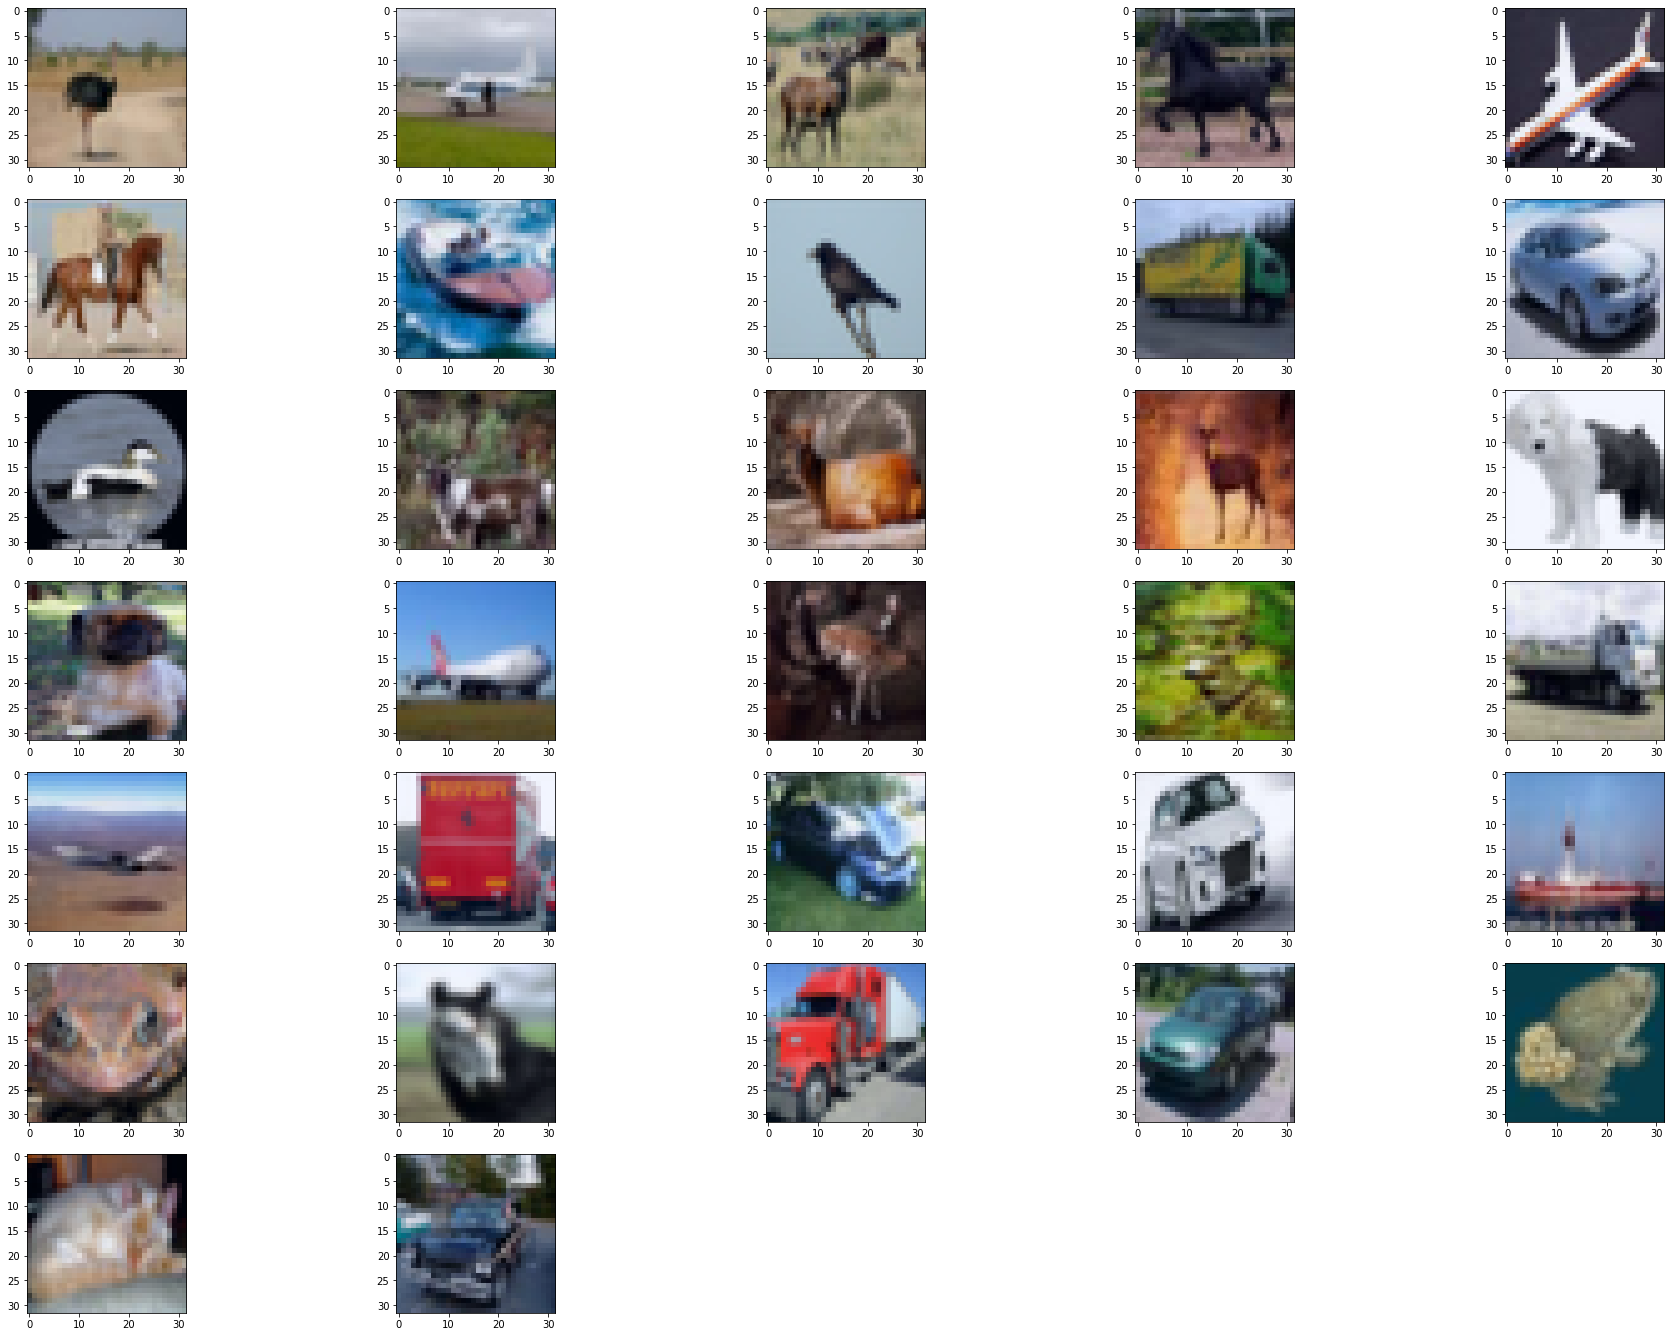

In [38]:
# now, lets visualize what augmenting the data actually looks like

plt.figure(figsize= (32,24))
Xbatch, Ybatch = train_flow.__getitem__(0)
for ii in range(batch_size):
  plt.subplot(7, 5, ii+1)
  plt.imshow((Xbatch[ii] - Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap='gray')
  # plt.title('Label: %s' %class_names[int(Ybatch[ii].argmax())])
plt.show()

## Fully Connected Model

## 5. Define your  model, cost function, optimizer, learning rate

In [ ]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_fully_connected():
    
    return

## 6. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_fcn = "team_(team number)_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!

## 7. Train your model

In [ ]:
# train your model - decide for how many epochs

## 8. Test your model

In [ ]:
model.load_weights(model_name_fcn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [ ]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_cnn():
    
    return

## 6. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_cnn = "team_(team number)_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!

## 7. Train your model

In [ ]:
# train your model - decide for how many epochs

## 8. Test your model

In [ ]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Arya Stark** helped design the model and write the code for fully connected model (**score 3**)
- **Luke Skywalker** helped design helped to implement the data augmentation module (**score 3**)
- ...